# First try D2Q9
## Lattice Boltzmann Method for Fluid Simulations
### by Sven Brieden

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import widgets          # for cool gadgets like a slider
#plt.style.use('dark_background')       # nice diagram style if you use a jupyter-dark-theme
plt.rcParams['figure.figsize'] = (15.0, 7.0)

## simulation parameters 
- nx and ny: number of cells in each direction
- nt: number of timesteps

In [25]:
nx, ny, nt = 300, 200, 50
τ = 1000
print("Estimated time to calculate: %.3f minutes" %(nx*ny*nt/28886/60))

Estimated time to calculate: 138.475 minutes


![](nodes.jpg)
## declare variables
- __f_in__, __f_out__: distribution function $f_i(\vec x)_{i = 0 . . . 8}$
- __$\rho$__: macroscopic fluid density $\rho(\vec x)$
- __u__: macroscopic velocity $\vec u(\vec x)$
- __e_i__: vectors of 9 possible stream directions $\vec e_i$
- __$\tau$__: viscosity of the fluid
- __u_liste__: list of calculated velocities $\vec u(\vec x, t)$

In [26]:
f_in, f_out = np.zeros([9,nx,ny]), np.zeros([9,nx,ny])
ρ = np.zeros([nx,ny])
u = np.zeros([2,nx,ny])
e_i = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1],  [1,1], [-1,1], [-1,-1], [1,-1]])
u_liste = np.zeros([nt,2, nx, ny])

## initial conditions
1. Definition a small number of particles in each cell. This gives the code more stability.
2. Set a initial impuls to see a movement

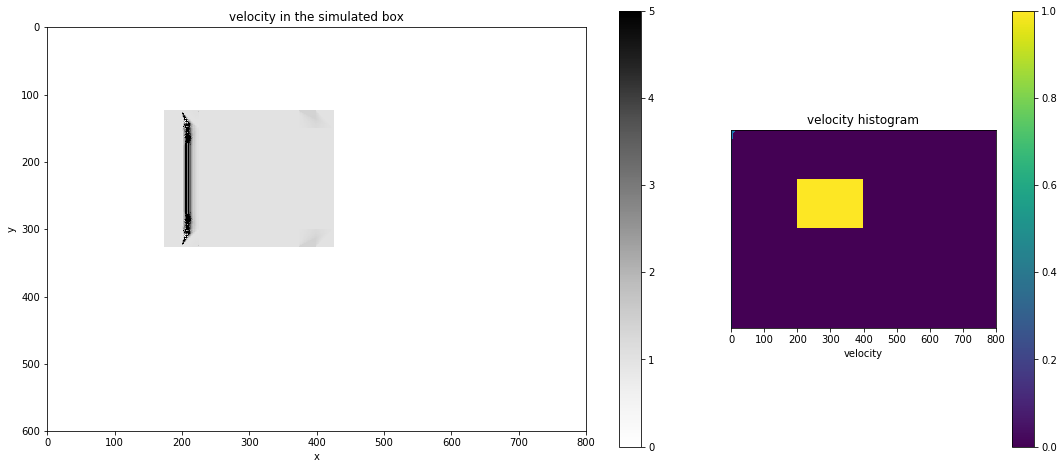

In [27]:
f_in[0,:,:] = 1e-10
f_in[1, int(nx/4):int(nx/2), int(ny/4):int(ny/2)] = 1

## macroscopic properties 
fluid density/ pressure:
$\vec \rho(\vec x, t) = \sum_{i = 0}^8 f_i$

macroscopic velocity: $\vec u(\vec x, t) = \frac{c}{\rho}\sum_{i = 0}^8 f_i \vec e_i$

In [28]:
def macroscopic(ρ,u):
    for xi in range(nx):
        for yi in range(ny):
            ρ[xi, yi] = 0
            u[0, xi, yi] = 0
            u[1, xi, yi] = 0
            for i in range(9):
                ρ[xi, yi] += f_in[i, xi, yi]
                u[0, xi, yi] += f_in[i, xi, yi] * e_i[i,0]
                u[1, xi, yi] += f_in[i, xi, yi] * e_i[i,1]
    u *= c/ρ
#    u[0,0,:] += 0.2      #Strömung
    return ρ, u

## equilibrium distribution
$f_i^{eq}(\vec x)=w_i\cdot \rho  + \rho \cdot s_i(\vec u(\vec x))$

__w_i__: weights for each streaming direction
$w_i = \left( \begin{matrix}
4/9  &i=0\\
1/9  &i=1,2,3,4\\
1/36  &i=5,6,7,8
\end{matrix} \right)$

$ s_i(\vec u) = w_i\left( 3 \cfrac{\vec e_i  \vec u}{c} + \cfrac{9}{2}\cfrac{(\vec e_i  \vec u)^2}{c^2}-\cfrac{3}{2}\cfrac{\vec u  \vec u}{c^2}\right)$

$c= \dfrac{\Delta x}{\Delta t}$ is the lattice speed.

In [29]:
w_i = np.array([ 4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
c = 1
def equilibrium(ρ, u):
    f_eq = np.zeros([9,nx,ny])
    uu = u[0]**2 + u[1]**2
    for i in range(9):
        e_iu = e_i[i,0] * u[0,:,:] + e_i[i,1] * u[1,:,:]
        s = w_i[i] * (3 * e_iu / c + 9 * e_iu**2/(2*c**2) - 3*uu/(2*c**2))
        f_eq[i,:,:] = w_i[i] * ρ + ρ * s
    return f_eq

## collide step
key step in LBM is the collision processe:
$$f^{out}_i(\vec x) - f^{in}_i(\vec x) = - \dfrac{f^{in}_i(\vec x)-f_i^{eq}(\vec x)}{\tau}$$

This results in the following:
$$f^{out}_i(\vec x) = - \left(f^{in}_i(\vec x,\, t)-f_i^{eq}(\vec x,\, t)\right)\frac{1}{\tau} +  f^{in}_i(\vec x,\, t)$$
$$f^{out}_i(\vec x) = \left(f_i^{eq}(\vec x,\, t) - f^{in}_i(\vec x,\, t)\right)\frac{1}{\tau} +  f^{in}_i(\vec x,\, t)$$

In [30]:
def collide_step(ρ,u,f_in):
    f_out =  (equilibrium(ρ, u) - f_in)/τ + f_in
    return f_out

## stream step
 streaming with harmonic boundary conditions
 $$f^{in}_i(\vec x + \vec e_i c  \Delta t,\, t + \Delta t) = f^{out}_i(\vec x, \, t)$$


In [ ]:
def stream_step(f_in,f_out):
    if 1:
        for i in range(9):
            f_in[i,:,:] = np.roll(
                            np.roll(f_out[i,:,:], e_i[i,0], axis=0),
                            e_i[i,1], axis=1 )
    if 0:
        for xi in range(nx):
            for yi in range(ny):
                for i in range(9):
                    x_next = xi + e_i[i,0]
                    if x_next < 0: x_next = nx-1
                    if x_next > nx-1: x_next = 0
                    y_next = yi + e_i[i,1]
                    if y_next < 0: y_next = ny-1
                    if y_next > ny-1:y_next = 0
                    f_in[i, x_next, y_next] = f_out[i, xi, yi]   
    return f_in

## main loop

In [ ]:
for step in range(nt):
    ρ,u = macroscopic(ρ,u)
    f_out = collide_step(ρ,u,f_in)
    f_in = stream_step(f_in,f_out)
    u_liste[step] = u

In [ ]:
def infosplot(t):
    u = u_liste[t]
#    v = np.sqrt(u[0]**2+u[1]**2)
    v = abs(u[0])
    
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    z1_plot = ax1.imshow(v.transpose(), vmin=0, vmax=5 , cmap=cm.Greys)
    ax1.set_title("velocity in the simulated box")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    plt.colorbar(z1_plot,ax=ax1)
    
    ax2 = plt.subplot2grid((1, 3), (0, 2))
    vliste = v.reshape(1, v.shape[0]*v.shape[1])
    ax2.hist(vliste[0,vliste[0]>0],100,(0,20))
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("velocity histogram")
    ax2.set_xlabel("velocity")
    plt.tight_layout()
    plt.show()
    
widgets.interact(infosplot, t=(0,nt-1))